# MSA 2D Backgrounds Textual Inversion Model

This is a guide to training a Stable Diffusuion model that learns the 2D background artstyle of _My Story Animated_.
This will run on <bigger>`GPU 4`</bigger> as specified in Cells 3 and 21.

#### Login to the Hugging Face Hub

[From Goolge Colab]: 

- _Add a token with the "Write Access" role to be able to add your trained concept to the [Library of Concepts](https://huggingface.co/sd-concepts-library)_

- _Make sure that we are using the latest libraries which support logging-in via tokens_

- _Install or simple upgrade to latest version (upgrade needed on kaggle notebook)_

- _For kaggle notebook, you may need to restart runtime to load the upgraded libraries correctly_


In [1]:
# Import the relavant libraries for logging in

from huggingface_hub import HfApi, HfFolder
import getpass

# get your account token from https://huggingface.co/settings/tokens
token = getpass.getpass("Enter token: ")

# set api for login and save token
api=HfApi()
api.set_access_token(token)
folder = HfFolder()
folder.save_token(token)
print("Login attempted. Token saved.")

Enter token:  ········


Login attempted. Token saved.


In [2]:
# Import required libraries for model

import argparse
import itertools
import math
import os
import random

import numpy as np
import torch
import torch.nn.functional as F
import torch.utils.checkpoint
from torch.utils.data import Dataset

import PIL
from accelerate import Accelerator
from accelerate.logging import get_logger
from accelerate.utils import set_seed
from diffusers import AutoencoderKL, DDPMScheduler, PNDMScheduler, StableDiffusionPipeline, UNet2DConditionModel
from diffusers.hub_utils import init_git_repo, push_to_hub
from diffusers.optimization import get_scheduler
from diffusers.pipelines.stable_diffusion import StableDiffusionSafetyChecker
from PIL import Image
from torchvision import transforms
from tqdm.auto import tqdm
from transformers import CLIPFeatureExtractor, CLIPTextModel, CLIPTokenizer

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

### [Optional] Specify a GPU to run the training on.

In [3]:
# Set a specific GPU
torch.cuda.set_device(4)

`pretrained_model_name_or_path` which Stable Diffusion checkpoint you want to use

In [4]:
pretrained_model_name_or_path = "CompVis/stable-diffusion-v1-4" #@param {type:"string"}

### Small script to obtain the image links from the corresponding Git repo.

In [37]:
# Scrape the image links from a target repo

import time
import bs4 as bs4
import requests
from urllib.parse import urljoin
import random

urls = []
sub_domain = "https://github.com/awwalm/MLDataSci"
load = requests.get("https://github.com/awwalm/MLDataSci/blob/master/MSA/BG2DCropped/Images.md")
soup = bs4.BeautifulSoup(load.content, "html.parser") if load.status_code == 200 else None
if soup is not None:
    article = soup.find("article")
    for a in article.find_all("a"):
        if a.img:
            urls.append(urljoin(sub_domain, a.img["src"]))

# Select 30 random images            
urls = [urls[u] for u in list(np.random.permutation(np.arange(0,101))[:30])]
print(f"images collected: {len(urls)}")
print(*urls, sep="\n")


images collected: 30
https://github.com/awwalm/MLDataSci/raw/master/MSA/BG2DCropped/BG0061.png
https://github.com/awwalm/MLDataSci/raw/master/MSA/BG2DCropped/BG0033.png
https://github.com/awwalm/MLDataSci/raw/master/MSA/BG2DCropped/BG0004.png
https://github.com/awwalm/MLDataSci/raw/master/MSA/BG2DCropped/BG0063.png
https://github.com/awwalm/MLDataSci/raw/master/MSA/BG2DCropped/BG0003.png
https://github.com/awwalm/MLDataSci/raw/master/MSA/BG2DCropped/BG0029.png
https://github.com/awwalm/MLDataSci/raw/master/MSA/BG2DCropped/BG0077.png
https://github.com/awwalm/MLDataSci/raw/master/MSA/BG2DCropped/BG0053.png
https://github.com/awwalm/MLDataSci/raw/master/MSA/BG2DCropped/BG0050.png
https://github.com/awwalm/MLDataSci/raw/master/MSA/BG2DCropped/BG0005.png
https://github.com/awwalm/MLDataSci/raw/master/MSA/BG2DCropped/BG0076.png
https://github.com/awwalm/MLDataSci/raw/master/MSA/BG2DCropped/BG0031.png
https://github.com/awwalm/MLDataSci/raw/master/MSA/BG2DCropped/BG0043.png
https://github.co

### Settings for your newly created concept

- `what_to_teach`: what is it that you are teaching? 

- `object` enables you to teach the model a new object to be used, 

- `style` allows you to teach the model a new style one can use.


In [5]:
what_to_teach = "style" #@param ["object", "style"]


`placeholder_token` is the token you are going to use to represent your new concept (so when you prompt the model, you will say "A `<my-placeholder-token>` in an amusement park"). We use angle brackets to differentiate a token from other words/tokens, to avoid collision.
`initializer_token` is a word that can summarise what your new concept is, to be used as a starting point

In [6]:
placeholder_token = "<msa-bg>" #@param {type:"string"}
initializer_token = "msabg" #@param {type:"string"}

### Setup and check the images you have just added

In [7]:
# Save path
save_path = "./my_concept"

### Display images in a grid

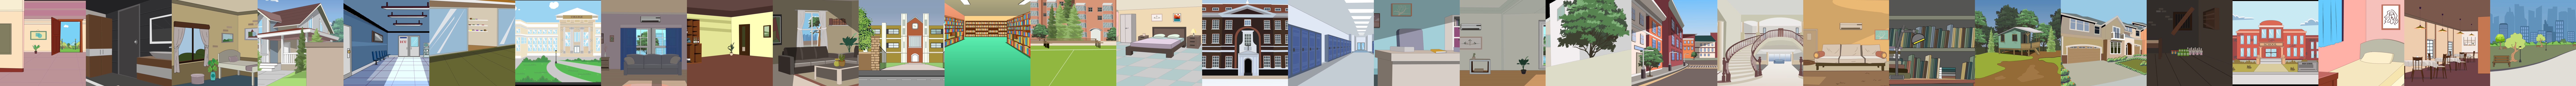

In [38]:
import requests
import glob
from io import BytesIO

def download_image(url):
  try:
    response = requests.get(url)
  except:
    return None
  return Image.open(BytesIO(response.content)).convert("RGB")

images = list(filter(None,[download_image(url) for url in urls]))
save_path = "./my_concept"
if not os.path.exists(save_path):
  os.mkdir(save_path)
[image.save(f"{save_path}/{i}.jpeg") for i, image in enumerate(images)]
image_grid(images, 1, len(images))

### Teach the model a new concept (fine-tuning with textual inversion)
Execute this this sequence of cells to run the training process. The whole process may take from 1-4 hours. (Open this block if you are interested in how this process works under the hood or if you want to change advanced training settings or hyperparameters)

## Create Dataset

### Setup the prompt templates for training

In [8]:
# Setup the prompt templates for training 

imagenet_templates_small = [
    "a photo of a {}",
    "a rendering of a {}",
    "a cropped photo of the {}",
    "the photo of a {}",
    "a photo of a clean {}",
    "a photo of a dirty {}",
    "a dark photo of the {}",
    "a photo of my {}",
    "a photo of the cool {}",
    "a close-up photo of a {}",
    "a bright photo of the {}",
    "a cropped photo of a {}",
    "a photo of the {}",
    "a good photo of the {}",
    "a photo of one {}",
    "a close-up photo of the {}",
    "a rendition of the {}",
    "a photo of the clean {}",
    "a rendition of a {}",
    "a photo of a nice {}",
    "a good photo of a {}",
    "a photo of the nice {}",
    "a photo of the small {}",
    "a photo of the weird {}",
    "a photo of the large {}",
    "a photo of a cool {}",
    "a photo of a small {}",
]

imagenet_style_templates_small = [
    "a painting in the style of {}",
    "a rendering in the style of {}",
    "a cropped painting in the style of {}",
    "the painting in the style of {}",
    "a clean painting in the style of {}",
    "a dirty painting in the style of {}",
    "a dark painting in the style of {}",
    "a picture in the style of {}",
    "a cool painting in the style of {}",
    "a close-up painting in the style of {}",
    "a bright painting in the style of {}",
    "a cropped painting in the style of {}",
    "a good painting in the style of {}",
    "a close-up painting in the style of {}",
    "a rendition in the style of {}",
    "a nice painting in the style of {}",
    "a small painting in the style of {}",
    "a weird painting in the style of {}",
    "a large painting in the style of {}",
]

### Setup the dataset

In [10]:
# Setup the dataset

class TextualInversionDataset(Dataset):
    def __init__(
        self,
        data_root,
        tokenizer,
        learnable_property="style",  # [object, style]
        size=512,
        repeats=100,
        interpolation="bicubic",
        flip_p=0.5,
        set="train",
        placeholder_token="*",
        center_crop=False,
    ):

        self.data_root = data_root
        self.tokenizer = tokenizer
        self.learnable_property = learnable_property
        self.size = size
        self.placeholder_token = placeholder_token
        self.center_crop = center_crop
        self.flip_p = flip_p

        self.image_paths = [os.path.join(self.data_root, file_path) for file_path in os.listdir(self.data_root)]

        self.num_images = len(self.image_paths)
        self._length = self.num_images

        if set == "train":
            self._length = self.num_images * repeats

        self.interpolation = {
            "linear": PIL.Image.LINEAR,
            "bilinear": PIL.Image.BILINEAR,
            "bicubic": PIL.Image.BICUBIC,
            "lanczos": PIL.Image.LANCZOS,
        }[interpolation]

        self.templates = imagenet_style_templates_small if learnable_property == "style" else imagenet_templates_small
        self.flip_transform = transforms.RandomHorizontalFlip(p=self.flip_p)

    def __len__(self):
        return self._length

    def __getitem__(self, i):
        example = {}
        image = Image.open(self.image_paths[i % self.num_images])

        if not image.mode == "RGB":
            image = image.convert("RGB")

        placeholder_string = self.placeholder_token
        text = random.choice(self.templates).format(placeholder_string)

        example["input_ids"] = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.tokenizer.model_max_length,
            return_tensors="pt",
        ).input_ids[0]

        # default to score-sde preprocessing
        img = np.array(image).astype(np.uint8)

        if self.center_crop:
            crop = min(img.shape[0], img.shape[1])
            h, w, = (
                img.shape[0],
                img.shape[1],
            )
            img = img[(h - crop) // 2 : (h + crop) // 2, (w - crop) // 2 : (w + crop) // 2]

        image = Image.fromarray(img)
        image = image.resize((self.size, self.size), resample=self.interpolation)

        image = self.flip_transform(image)
        image = np.array(image).astype(np.uint8)
        image = (image / 127.5 - 1.0).astype(np.float32)

        example["pixel_values"] = torch.from_numpy(image).permute(2, 0, 1)
        return example

### Setting up the model

### Load the tokenizer and add the placeholder token as a additional special token.

Please read and if you agree accept the LICENSE [here](https://huggingface.co/CompVis/stable-diffusion-v1-4) if you see an error

In [11]:
tokenizer = CLIPTokenizer.from_pretrained(
    pretrained_model_name_or_path,
    subfolder="tokenizer",
)

# Add the placeholder token in tokenizer
num_added_tokens = tokenizer.add_tokens(placeholder_token)
if num_added_tokens == 0:
    print("Error occured:\t")
    raise ValueError(
        f"The tokenizer already contains the token {placeholder_token}. Please pass a different"
        " `placeholder_token` that is not already in the tokenizer."
    )

### Get token ids for our placeholder and initializer token. 

This code block will complain if initializer string is not a single token

In [12]:
# Convert the initializer_token, placeholder_token to ids

token_ids = tokenizer.encode(initializer_token, add_special_tokens=False)
# Check if initializer_token is a single token or a sequence of tokens
#if len(token_ids) > 1:
#    raise ValueError("The initializer token must be a single token.")

initializer_token_id = token_ids[0]
placeholder_token_id = tokenizer.convert_tokens_to_ids(placeholder_token)

### Load the Stable Diffusion model

In [13]:
# Load models and create wrapper for stable diffusion

text_encoder = CLIPTextModel.from_pretrained(
    pretrained_model_name_or_path, subfolder="text_encoder"
)
vae = AutoencoderKL.from_pretrained(
    pretrained_model_name_or_path, subfolder="vae"
)
unet = UNet2DConditionModel.from_pretrained(
    pretrained_model_name_or_path, subfolder="unet"
)

We have added the `placeholder_token` in the `tokenizer` so we resize the token embeddings here, this will a new embedding vector in the token embeddings for our `placeholder_token`

In [14]:
text_encoder.resize_token_embeddings(len(tokenizer))

Embedding(49409, 768)

 Initialise the newly added placeholder token with the embeddings of the initializer token

In [15]:
token_embeds = text_encoder.get_input_embeddings().weight.data
token_embeds[placeholder_token_id] = token_embeds[initializer_token_id]

In Textual-Inversion we only train the newly added embedding vector, so lets freeze rest of the model parameters here

In [16]:
def freeze_params(params):
    for param in params:
        param.requires_grad = False

# Freeze vae and unet
freeze_params(vae.parameters())
freeze_params(unet.parameters())
# Freeze all parameters except for the token embeddings in text encoder
params_to_freeze = itertools.chain(
    text_encoder.text_model.encoder.parameters(),
    text_encoder.text_model.final_layer_norm.parameters(),
    text_encoder.text_model.embeddings.position_embedding.parameters(),
)
freeze_params(params_to_freeze)

### Creating our training data

Let's create the Dataset and Dataloader

In [17]:
train_dataset = TextualInversionDataset(
      data_root=save_path,
      tokenizer=tokenizer,
      size=512,
      placeholder_token=placeholder_token,
      repeats=100,
      learnable_property=what_to_teach, #Option selected above between object and style
      center_crop=False,
      set="train",
)

/tmp/ipykernel_18740/2842112153.py:35: DeprecationWarning: LINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  "linear": PIL.Image.LINEAR,
/tmp/ipykernel_18740/2842112153.py:36: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  "bilinear": PIL.Image.BILINEAR,
/tmp/ipykernel_18740/2842112153.py:37: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  "bicubic": PIL.Image.BICUBIC,
/tmp/ipykernel_18740/2842112153.py:38: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  "lanczos": PIL.Image.LANCZOS,


### This is where batch size is declared

In [18]:
def create_dataloader(train_batch_size=1):
    return torch.utils.data.DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)

Create noise_scheduler for training

In [19]:
noise_scheduler = DDPMScheduler(
    beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000, tensor_format="pt"
)

Define hyperparameters for our training
If you are not happy with your results, you can tune the `learning_rate` and the `max_train_steps`

In [20]:
hyperparameters = {
    "learning_rate": 5e-04,
    "scale_lr": True,
    "max_train_steps": 3000, # Iterations?
    "train_batch_size": 2, # 1, # Why 1? Setting to 10
    "gradient_accumulation_steps": 3,
    "seed": 42,
    "output_dir": "sd-concept-output"
}

## Begin training!
Ignore if model has been pretrained.

In [52]:
import accelerate
import time

def training_function(text_encoder, vae, unet):
    logger = get_logger(__name__)

    train_batch_size = hyperparameters["train_batch_size"]
    gradient_accumulation_steps = hyperparameters["gradient_accumulation_steps"]
    learning_rate = hyperparameters["learning_rate"]
    max_train_steps = hyperparameters["max_train_steps"]
    output_dir = hyperparameters["output_dir"]

    accelerator = Accelerator(
        gradient_accumulation_steps=gradient_accumulation_steps #, split_batches=True
    )

    # accelerator.state.distributed_type = DistributedType.MULTI_GPU
    # accelerator.state.num_processes = 5

    train_dataloader = create_dataloader(train_batch_size)

    if hyperparameters["scale_lr"]:
        learning_rate = (
            learning_rate * gradient_accumulation_steps * train_batch_size * accelerator.num_processes
        )

    # Initialize the optimizer
    optimizer = torch.optim.AdamW(
        text_encoder.get_input_embeddings().parameters(),  # only optimize the embeddings
        lr=learning_rate,
    )


    text_encoder, optimizer, train_dataloader = accelerator.prepare(
        text_encoder, optimizer, train_dataloader
    )

    # Move vae and unet to device
    vae.to(accelerator.device)
    unet.to(accelerator.device)

    # Keep vae and unet in eval model as we don't train these
    vae.eval()
    unet.eval()

    # We need to recalculate our total training steps as the size of the training dataloader may have changed.
    num_update_steps_per_epoch = math.ceil(len(train_dataloader) / gradient_accumulation_steps)
    num_train_epochs = math.ceil(max_train_steps / num_update_steps_per_epoch)

    # Train!
    total_batch_size = train_batch_size * accelerator.num_processes * gradient_accumulation_steps

    logger.info("***** Running training *****")
    logger.info(f"  Num examples = {len(train_dataset)}")
    logger.info(f"  Instantaneous batch size per device = {train_batch_size}")
    logger.info(f"  Total train batch size (w. parallel, distributed & accumulation) = {total_batch_size}")
    logger.info(f"  Gradient Accumulation steps = {gradient_accumulation_steps}")
    logger.info(f"  Total optimization steps = {max_train_steps}")
    
    print(f"""
    total_batch_size = train_batch_size * accelerator.num_processes * gradient_accumulation_steps
    total_batch_size = {train_batch_size} * {accelerator.num_processes} * {gradient_accumulation_steps}
    total_batch_size = {total_batch_size:.4f}
    
    num_update_steps_per_epoch = math.ceil(len(train_dataloader) / gradient_accumulation_steps)
    num_update_steps_per_epoch = math.ceil({len(train_dataloader)} / {gradient_accumulation_steps})
    num_update_steps_per_epoch = {num_update_steps_per_epoch:.4f}
    
    num_train_epochs = math.ceil(max_train_steps / num_update_steps_per_epoch)
    num_train_epochs = math.ceil({max_train_steps} / {num_update_steps_per_epoch})
    num_train_epochs = {num_train_epochs}
    
    Num examples = {len(train_dataset)}
    Instantaneous batch size per device = {train_batch_size}"
    Total train batch size (w. parallel, distributed & accumulation) = {total_batch_size}
    Gradient Accumulation steps = {gradient_accumulation_steps}
    Total optimization steps = {max_train_steps}
    """)
    
    # Only show the progress bar once on each machine.
    progress_bar = tqdm(range(max_train_steps), disable=not accelerator.is_local_main_process)
    progress_bar.set_description("Steps")
    global_step = 0

    for epoch in range(num_train_epochs):
        text_encoder.train()
        for step, batch in enumerate(train_dataloader):
            with accelerator.accumulate(text_encoder):
                # Convert images to latent space
                latents = vae.encode(batch["pixel_values"]).latent_dist.sample().detach()
                latents = latents * 0.18215

                # Sample noise that we'll add to the latents
                noise = torch.randn(latents.shape).to(latents.device)
                bsz = latents.shape[0]
                # Sample a random timestep for each image
                timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (bsz,), device=latents.device).long()

                # Add noise to the latents according to the noise magnitude at each timestep
                # (this is the forward diffusion process)
                noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

                # Get the text embedding for conditioning
                encoder_hidden_states = text_encoder(batch["input_ids"])[0]

                # Predict the noise residual
                noise_pred = unet(noisy_latents, timesteps, encoder_hidden_states).sample

                loss = F.mse_loss(noise_pred, noise, reduction="none").mean([1, 2, 3]).mean()
                accelerator.backward(loss)

                # Zero out the gradients for all token embeddings except the newly added
                # embeddings for the concept, as we only want to optimize the concept embeddings
                if accelerator.num_processes > 1:
                    grads = text_encoder.module.get_input_embeddings().weight.grad
                else:
                    grads = text_encoder.get_input_embeddings().weight.grad
                # Get the index for tokens that we want to zero the grads for
                index_grads_to_zero = torch.arange(len(tokenizer)) != placeholder_token_id
                grads.data[index_grads_to_zero, :] = grads.data[index_grads_to_zero, :].fill_(0)

                optimizer.step()
                optimizer.zero_grad()

            # Checks if the accelerator has performed an optimization step behind the scenes
            if accelerator.sync_gradients:
                progress_bar.update(1)
                global_step += 1

            logs = {"loss": loss.detach().item()}
            progress_bar.set_postfix(**logs)

            if global_step >= max_train_steps:
                break

        accelerator.wait_for_everyone()


    # Create the pipeline using using the trained modules and save it.
    if accelerator.is_main_process:
        pipeline = StableDiffusionPipeline(
            text_encoder=accelerator.unwrap_model(text_encoder),
            vae=vae,
            unet=unet,
            tokenizer=tokenizer,
            scheduler=PNDMScheduler(
                beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", skip_prk_steps=True
            ),
            safety_checker=StableDiffusionSafetyChecker.from_pretrained("CompVis/stable-diffusion-safety-checker"),
            feature_extractor=CLIPFeatureExtractor.from_pretrained("openai/clip-vit-base-patch32"),
        )
        pipeline.save_pretrained(output_dir)
        # Also save the newly trained embeddings
        learned_embeds = accelerator.unwrap_model(text_encoder).get_input_embeddings().weight[placeholder_token_id]
        learned_embeds_dict = {placeholder_token: learned_embeds.detach().cpu()}
        torch.save(learned_embeds_dict, os.path.join(output_dir, "learned_embeds.bin"))


# Call training function
t0 = time.time()        
accelerate.notebook_launcher(training_function, args=(text_encoder, vae, unet), num_processes=1)
print(f"Time taken: {(time.time() - t0):.2f}")
print(f"Seconds per step: {((time.time() - t0)/3000):.2f}")


Launching training on one GPU.

    total_batch_size = train_batch_size * accelerator.num_processes * gradient_accumulation_steps
    total_batch_size = 2 * 1 * 3
    total_batch_size = 6.0000
    
    num_update_steps_per_epoch = math.ceil(len(train_dataloader) / gradient_accumulation_steps)
    num_update_steps_per_epoch = math.ceil(1500 / 3)
    num_update_steps_per_epoch = 500.0000
    
    num_train_epochs = math.ceil(max_train_steps / num_update_steps_per_epoch)
    num_train_epochs = math.ceil(3000 / 500)
    num_train_epochs = 6
    
    Num examples = 3000
    Instantaneous batch size per device = 2"
    Total train batch size (w. parallel, distributed & accumulation) = 6
    Gradient Accumulation steps = 3
    Total optimization steps = 3000
    


  0%|          | 0/3000 [00:00<?, ?it/s]

Time taken: 4274.29
Seconds per step: 1.42


In [21]:
# Set up the pipeline 

pipe = StableDiffusionPipeline.from_pretrained(
    hyperparameters["output_dir"],
    torch_dtype=torch.float16,
).to("cuda:4") # this goes to the 4th GPU, use "cuda" or "cuda:n" to specify a particular GPU

In [22]:
#@title Disable overreactive NSFW filter
def dummy_checker(images, **kwargs): return images, False
pipe.safety_checker = dummy_checker

In [59]:
# Prompt and render

import time

save_all_imgs = True # Set to True if you don't want to accummulate every saved output
FORMAT = "high resolution digital art"
CONTEXT = "luxury female bedroom"
MODIFIER = "highly detailed, realistic outlines and shapes, with background artefacts, dramatic lighting"
STYLE = "in the style of <msa-bg>"

prompt = f"{FORMAT} of a {CONTEXT}, {MODIFIER}, {STYLE}"

t0 = time.time()
tz = t0
num_samples = 3 #@param {type:"number"}
num_rows = 2 #@param {type:"number"}
img_count = num_samples * num_rows

all_images = [] 
for _ in range(num_rows):
    images = pipe([prompt] * num_samples, width=864, height=480, num_inference_steps=160, guidance_scale=17).images
    all_images.extend(images)
    t_ij = time.time() - t0
    print(f"{num_samples} images generated in: {t_ij:.2f}s ({t_ij/num_samples:.2f}s/img)")
    t0 = time.time()
    for im in images:
        im.save(f"rendered/{CONTEXT}_{img_count}_{time.time()}.png") if not save_all_imgs \
        else im.save(f"rendered/{CONTEXT}_{img_count}.png")
        img_count -= 1
    
print(f"Total time taken: {num_samples * num_rows} images in {(time.time() - tz):.2f}\n'{prompt}'")

grid = image_grid(all_images, num_samples, num_rows)
grid

  0%|          | 0/161 [00:00<?, ?it/s]

3 images generated in: 58.08s (19.36s/img)


  0%|          | 0/161 [00:00<?, ?it/s]

3 images generated in: 59.05s (19.68s/img)
Total time taken: 6 images in 117.54
